<a href="https://colab.research.google.com/github/mridul-eecs/fast_ai/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install duckduckgo_search
!pip install ipython-autotime
%load_ext autotime

In [ ]:
from fastdownload import download_url
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
from tqdm import tqdm_notebook as tqdm

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

time: 226 ms (started: 2023-05-11 02:34:19 +00:00)


In [44]:
url= 'https://amazinganimalphotos.com/wp-content/uploads/2016/11/beautiful-birds.jpeg'
urls= search_images("crocodile photos")

Searching for 'crocodile photos'
time: 986 ms (started: 2023-05-11 03:43:16 +00:00)


### Download images using duckduckgo_search and fastdownload

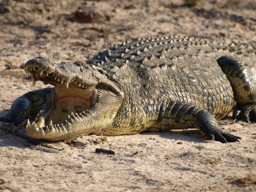

time: 71.1 ms (started: 2023-05-11 03:43:20 +00:00)


In [45]:
from fastdownload import download_url
dest = 'crocodile.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [6]:
searches = 'bear','bird','lion', 'crocodile'
path = Path('animals')
from time import sleep

for o in tqdm(searches):
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

<ipython-input-6-590810aa1dc9>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for o in tqdm(searches):


  0%|          | 0/4 [00:00<?, ?it/s]

Searching for 'bear photo'
Searching for 'bear sun photo'
Searching for 'bear shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'
Searching for 'lion photo'
Searching for 'lion sun photo'
Searching for 'lion shade photo'
Searching for 'crocodile photo'
Searching for 'crocodile sun photo'
Searching for 'crocodile shade photo'
time: 3min 44s (started: 2023-05-11 03:21:31 +00:00)


### verify and remove failed downloads

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

time: 1.01 s (started: 2023-05-11 03:25:16 +00:00)


### Training with dataloaders

In [8]:
from fastai.vision.augment import aug_transforms

dls= DataBlock(
    blocks= (ImageBlock, CategoryBlock),
    get_items= get_image_files,
    splitter= RandomSplitter(valid_pct= 0.2, seed= 123),
    get_y= parent_label,
    item_tfms= [Resize(192, method= "squish")],
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)



"""
Here what each of the DataBlock parameters means:

blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

get_items=get_image_files, 

To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).

splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

get_y=parent_label,

The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).

item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).
"""

'\nHere what each of the DataBlock parameters means:\n\nblocks=(ImageBlock, CategoryBlock),\n\nThe inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").\n\nget_items=get_image_files, \n\nTo find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).\n\nsplitter=RandomSplitter(valid_pct=0.2, seed=42),\n\nSplit the data into training and validation sets randomly, using 20% of the data for the validation set.\n\nget_y=parent_label,\n\nThe labels (y values) is the name of the parent of each file (i.e. the name of the folder they\'re in, which will be bird or forest).\n\nitem_tfms=[Resize(192, method=\'squish\')]\n\nBefore training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).\n'

time: 7.33 s (started: 2023-05-11 03:25:17 +00:00)


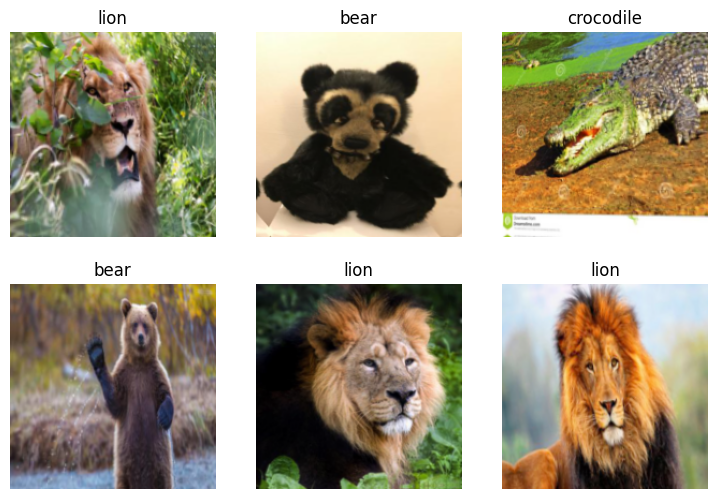

time: 775 ms (started: 2023-05-11 03:25:24 +00:00)


In [9]:
dls.show_batch(max_n=6)

In [68]:
epochs= 50

## Option1 (Pretrained Network)
# pretrained_learn = vision_learner(dls, mobilenet_v3_small, metrics=error_rate)
pretrained_learn = vision_learner(dls, resnet18, metrics=error_rate)
pretrained_learn.fine_tune(epochs)

## Option2 (Custom Network)
class myNet(nn.Module): 
    def __init__(self, num_classes, pretrained= None):
        super().__init__()
        self.pretrained= pretrained
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x, pretrained= None):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
# # Create learner object
myNet_learn = Learner(dls, myNet(num_classes=dls.c), metrics=accuracy)
# Train the model
myNet_learn.fine_tune(epochs, base_lr= 1.2022644114040304e-05)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the 

epoch,train_loss,valid_loss,error_rate,time
0,1.569978,0.276873,0.088235,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.302995,0.239835,0.102941,00:02
1,0.273541,0.188531,0.088235,00:03
2,0.221069,0.145622,0.058824,00:02
3,0.196251,0.125471,0.058824,00:02
4,0.172768,0.115787,0.058824,00:02
5,0.148028,0.106925,0.044118,00:02
6,0.120876,0.104310,0.044118,00:03
7,0.102070,0.138690,0.058824,00:02
8,0.084384,0.163208,0.073529,00:02
9,0.075269,0.199901,0.058824,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.388350,1.387734,0.191176,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.356384,1.381802,0.294118,00:02
1,1.346754,1.365927,0.323529,00:02
2,1.339160,1.331741,0.426471,00:02
3,1.329320,1.288920,0.558824,00:03
4,1.318610,1.247146,0.602941,00:03
5,1.308021,1.208455,0.676471,00:02
6,1.293013,1.170484,0.676471,00:02
7,1.277392,1.144722,0.602941,00:03
8,1.262142,1.093601,0.647059,00:03
9,1.244774,1.063472,0.661765,00:02


time: 4min 54s (started: 2023-05-11 04:30:11 +00:00)


SuggestedLRs(valley=3.630780702224001e-05)

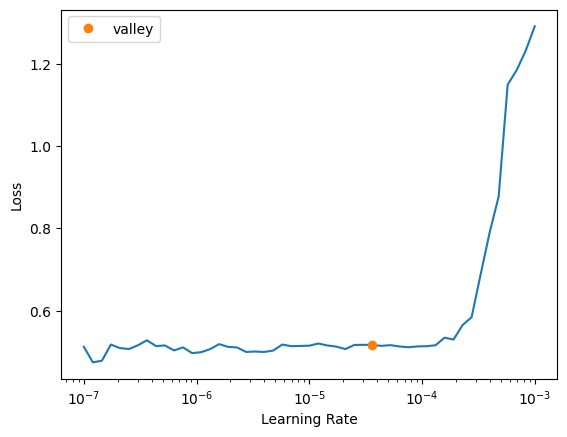

time: 26.6 s (started: 2023-05-11 04:35:48 +00:00)


In [71]:
myNet_learn.lr_find()

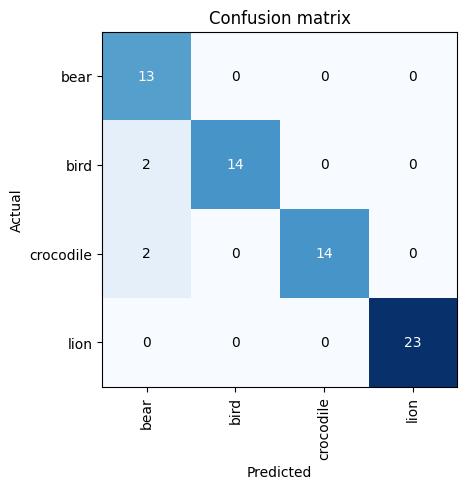

time: 1.47 s (started: 2023-05-11 04:36:33 +00:00)


In [72]:
interp= ClassificationInterpretation.from_learner(pretrained_learn)
interp.plot_confusion_matrix()

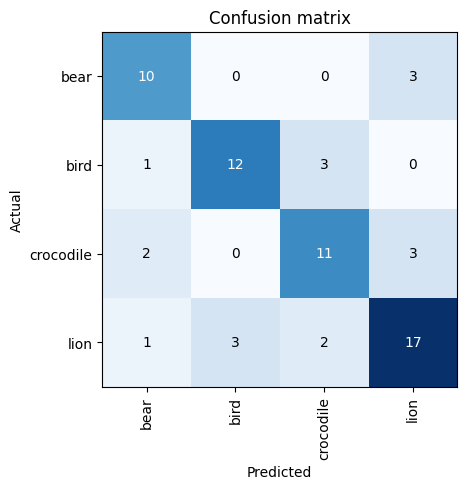

time: 1.57 s (started: 2023-05-11 04:36:42 +00:00)


In [73]:
interp= ClassificationInterpretation.from_learner(myNet_learn)
interp.plot_confusion_matrix()

In [74]:
import pickle
with open("model.pickle", "wb") as file:
  pickle.dump(myNet_learn, file)

time: 6.87 s (started: 2023-05-11 04:37:27 +00:00)


### load the model and predict

In [75]:
with open("model.pickle", "rb") as file:
  model= pickle.load(file)

time: 2.68 s (started: 2023-05-11 04:37:33 +00:00)


In [76]:
model.model= model.model.to('cuda')

time: 2.32 ms (started: 2023-05-11 04:37:36 +00:00)


In [77]:
is_bird,_,probs = model.predict(PILImage.create('crocodile.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bear: {probs[0]:.4f}")
print(f"Probability it's a bird: {probs[1]:.4f}")
print(f"Probability it's a crocodile: {probs[2]:.4f}")
print(f"Probability it's a lion: {probs[3]:.4f}")

This is a: crocodile.
Probability it's a bear: 0.0005
Probability it's a bird: 0.0005
Probability it's a crocodile: 0.9972
Probability it's a lion: 0.0018
time: 108 ms (started: 2023-05-11 04:37:37 +00:00)


In [78]:
model.model= model.model.to('cpu')

time: 331 ms (started: 2023-05-11 04:37:45 +00:00)


In [79]:
is_bird,_,probs = model.predict(PILImage.create('bear.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bear: {probs[0]:.4f}")
print(f"Probability it's a bird: {probs[1]:.4f}")
print(f"Probability it's a crocodile: {probs[2]:.4f}")
print(f"Probability it's a lion: {probs[3]:.4f}")

This is a: bear.
Probability it's a bear: 0.8226
Probability it's a bird: 0.0793
Probability it's a crocodile: 0.0386
Probability it's a lion: 0.0595
time: 482 ms (started: 2023-05-11 04:37:55 +00:00)
